# Project: “Identification of Internet Users”

# Part 3. Visual data analysis and feature construction

## 1. Building features

In [1]:
import os
import re
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
pattern = r'\d{4}'

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    '''
    The function creates a table of sessions with additional attributes.
    
    Parameters:
    path_to_csv_files - path to users' csv files
    site_freq_path - path to the site frequency dictionary in pickle format
    feature_names - list of names of feature columns
    session_length - session length
    window_size - window width
    
    Return:
    DataFrame containing a table with user sessions and additional attributes created for it.
    '''
    
    sites_per_session = list()
    
    # Reading site index dictionary
    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)    
    
    for usr in tqdm(glob(path_to_csv_files + '\\user*.csv'), desc='users'):        
        # Reading the queue of visited sites by the user
        sites_queue = pd.read_csv(usr).site.to_list()      
        
        # Timestamp reading
        sites_tmstmp = pd.read_csv(usr).timestamp.to_list()
        
        # Calculate the start indexes of the sessions
        indexes = list()
        i = 0
        while i < len(sites_queue):
            indexes.append(i)
            i += window_size
        
        # Creation of the table sessions/websites        
        for i in indexes:
            # Creation of a session
            sites_per_session.append(list(map(lambda site: site_dict[site][0], sites_queue[i:i+session_length])))
            
            # Counting unique sites in a session
            unique_sites = len(set(sites_per_session[-1]))
            
            # Adding zeros if necessary            
            while len(sites_per_session[-1]) != session_length:
                sites_per_session[-1].append(0)
            
            # Adding time_diff attributes
            time_list = list() # To determine the minimum / maximum date
            for j in range(i, i+session_length-1):
                if (len(sites_tmstmp) - j) < 2: break # Complete if there are no 2 elements for the difference
                time_curr = datetime.strptime(sites_tmstmp[j], '%Y-%m-%d %X')
                time_next = datetime.strptime(sites_tmstmp[j+1], '%Y-%m-%d %X')
                time_diff = time_next - time_curr
                sites_per_session[-1].append(time_diff.seconds)
                # To determine the minimum / maximum date
                time_list.append(time_curr)
                time_list.append(time_next)
                
            # Adding zeros if necessary
            while len(sites_per_session[-1]) != 2 * session_length - 1:
                sites_per_session[-1].append(0)            
                
            # Adding the session_timespan attribute
            if len(time_list) > 0:
                session_timespan = max(time_list) - min(time_list)
                sites_per_session[-1].append(session_timespan.seconds)
            else:
                sites_per_session[-1].append(0)
            
            # Adding the #unique_sites attribute
            sites_per_session[-1].append(unique_sites)
            
            # Adding the start_hour attribute
            start_hour = datetime.strptime(sites_tmstmp[i], '%Y-%m-%d %X').hour
            sites_per_session[-1].append(start_hour)
            
            # Adding the day_of_week attribute
            day_of_week = datetime.strptime(sites_tmstmp[i], '%Y-%m-%d %X').weekday()
            sites_per_session[-1].append(day_of_week)
            
            # Adding the user id (target)
            sites_per_session[-1].append(int(*re.findall(pattern, usr)))    
    
    return pd.DataFrame(sites_per_session, columns=feature_names)

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']

In [5]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           feature_names=feature_names, session_length=10)

users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


Wall time: 3.61 s


In [6]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


In [7]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           feature_names=feature_names, session_length=10)

users: 100%|█████████████████████████████████████████████████████████████████████████| 150/150 [00:33<00:00,  4.52it/s]


Wall time: 34.1 s


**Save the attributes *session_timespan*, *#unique_sites*, *start_hour to pickle files* and *day_of_week* for 10 and 150 users:**

In [8]:
new_features_name = ['session_timespan', '#unique_sites', 'start_hour']
new_features_10users = train_data_10users[new_features_name].values.tolist()
new_features_150users = train_data_150users[new_features_name].values.tolist()

In [9]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**Median duration of the session for the sessions:**

In [10]:
print('10 users:', train_data_10users['session_timespan'].median())
print('150 users:', train_data_150users['session_timespan'].median())

10 users: 37.0
150 users: 26.0


**Median day of the week when the session started, for sessions:**

In [11]:
print('10 users:', train_data_10users['day_of_week'].median())
print('150 users:', train_data_150users['day_of_week'].median())

10 users: 2.0
150 users: 2.0


**Median session start hour for sessions:**

In [12]:
print('10 users:', train_data_10users['start_hour'].median())
print('150 users:', train_data_150users['start_hour'].median())

10 users: 14.0
150 users: 13.0


**Median number of unique sites in user sessions:**

In [13]:
print('10 users:', train_data_10users['#unique_sites'].median())
print('150 users:', train_data_150users['#unique_sites'].median())

10 users: 6.0
150 users: 7.0


## 2. Visual data analysis

**For convenience, we will set users names and associate colors with them:**

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [15]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**Histogram of the distribution of the session length in seconds (* session_timespan *):**

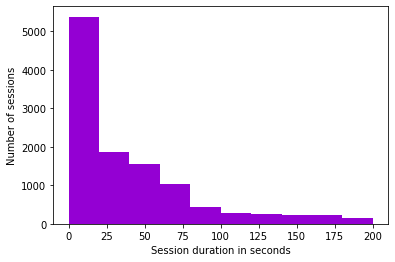

In [16]:
plt.hist(train_data_10users['session_timespan'], range=(0,200), color='darkviolet')
plt.xlabel('Session duration in seconds')
plt.ylabel('Number of sessions')
plt.show()

**Histogram of the distribution of the number of unique sites in the session (*#unique_sites*):**

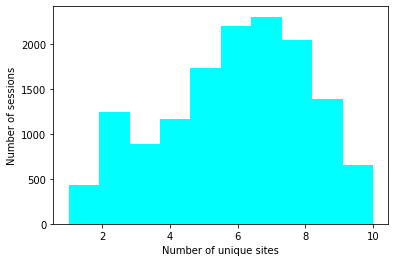

In [17]:
plt.hist(train_data_10users['#unique_sites'], color='aqua')
plt.xlabel('Number of unique sites')
plt.ylabel('Number of sessions')
plt.show()

**Histograms of the distribution of the number of unique sites in a session (*#unique_sites*) for each of the 10 users individually:**

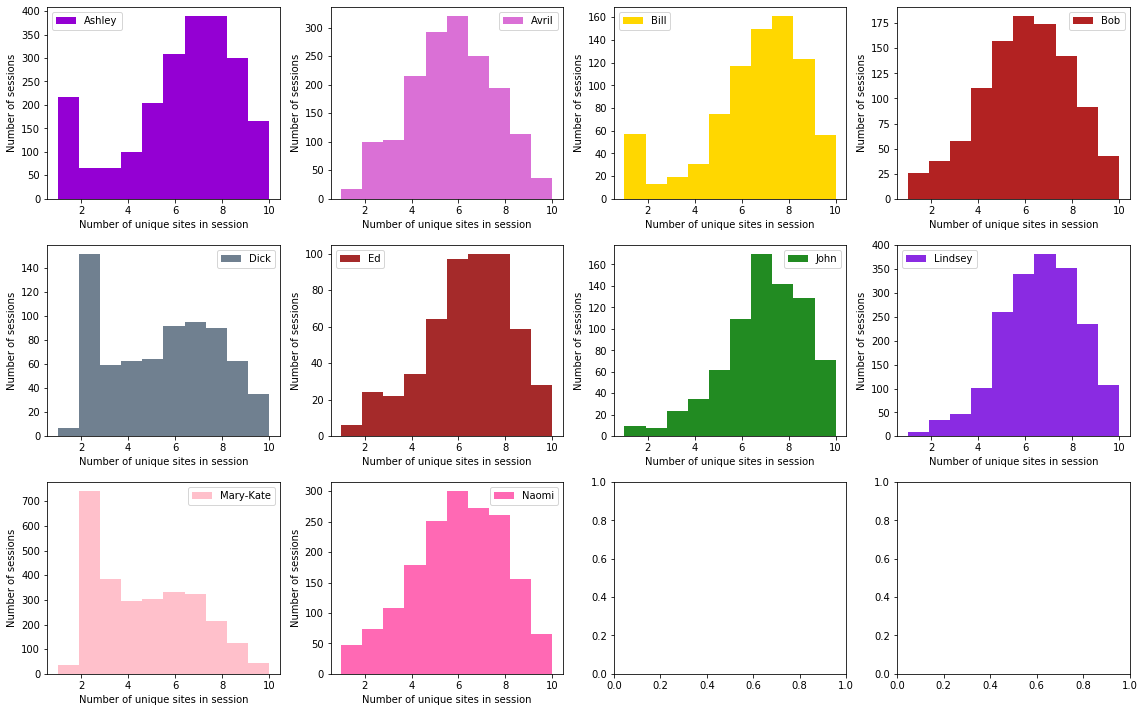

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes = axes.ravel()
for idx, (user, sub_df) in enumerate(pd.DataFrame.groupby(train_data_10users, 'target')):   
    axes[idx].hist(sub_df['#unique_sites'], label=user, color=color_dic[user])
    axes[idx].set_xlabel('Number of unique sites in session')
    axes[idx].set_ylabel('Number of sessions')
    axes[idx].legend()

fig.tight_layout()

The average number of unique sites per session is 6. It is noticeable that Ashley and Bill have a large number of sessions consisting of only 1-2 unique sites. Not far from them, due to the "strangeness" of their behavior, went Dick and Mary-Kate, who have a number of unique sites in most sessions is in the region of 2-3.

**Histogram of the session start hour distribution (*start_hour*):**

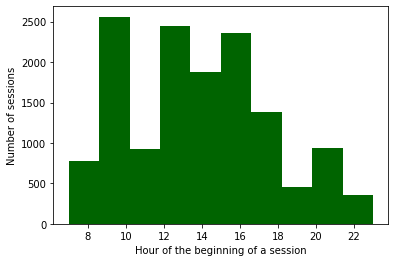

In [19]:
plt.hist(train_data_10users['start_hour'], color='darkgreen')
plt.xlabel('Hour of the beginning of a session')
plt.ylabel('Number of sessions')
plt.show()

**Histograms of the session start hour distribution (*start_hour*) for each of the 10 users individually:**

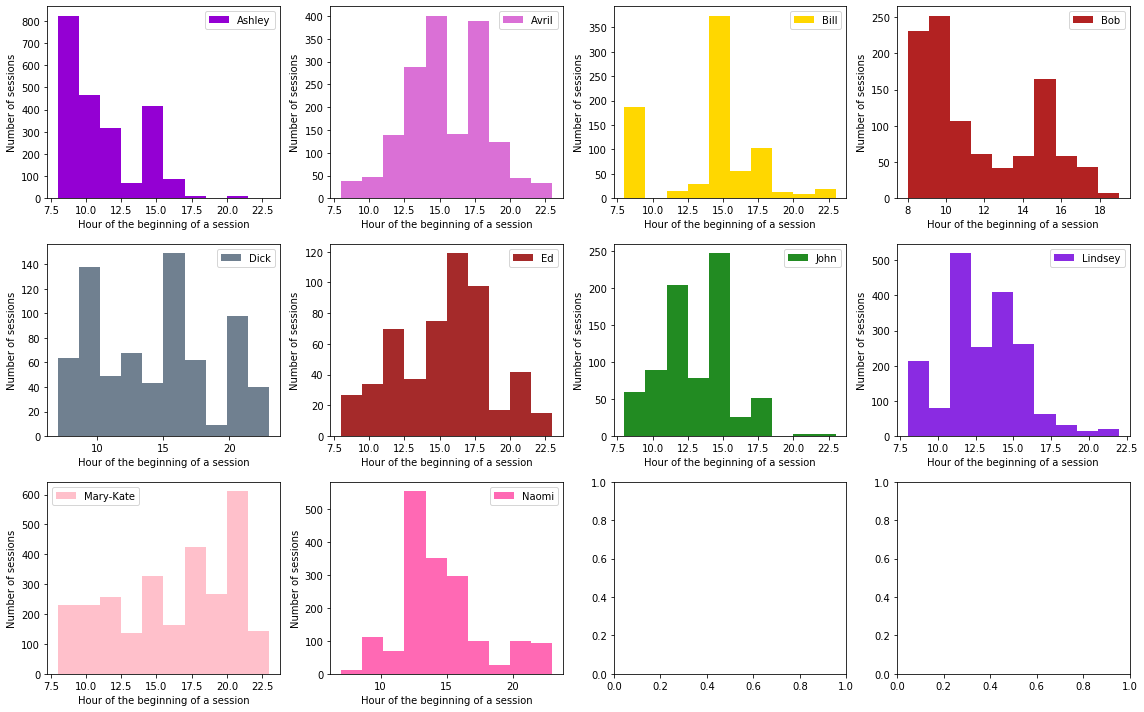

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes = axes.ravel()
for idx, (user, sub_df) in enumerate(pd.DataFrame.groupby(train_data_10users, 'target')):   
    axes[idx].hist(sub_df['start_hour'], label=user, color=color_dic[user])
    axes[idx].set_xlabel('Hour of the beginning of a session')
    axes[idx].set_ylabel('Number of sessions')
    axes[idx].legend()

fig.tight_layout()

Ashley, Bill, Bob and Lindsey have a large proportion of sessions starting at 9 and 15 hours. At Avrill, Naomi - most of the sessions begin in the afternoon (from 12 to 18 hours). At Dick, Ed, John, Mary-Kate - most of the sessions are distributed from 8 hours to 18 hours.

**Histogram of the distribution of the day of the week on which the session began (* day_of_week *):**

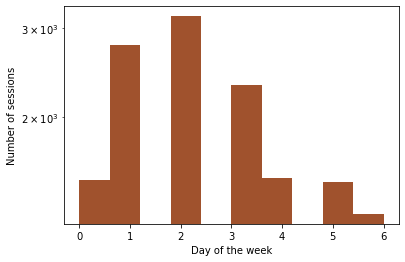

In [21]:
plt.hist(train_data_10users['day_of_week'], color='sienna', log=True)
plt.xlabel('Day of the week')
plt.ylabel('Number of sessions')
plt.show()

**Histograms of the distribution of the day of the week when the session started (*day_of_week*) for each of the 10 users separately:**

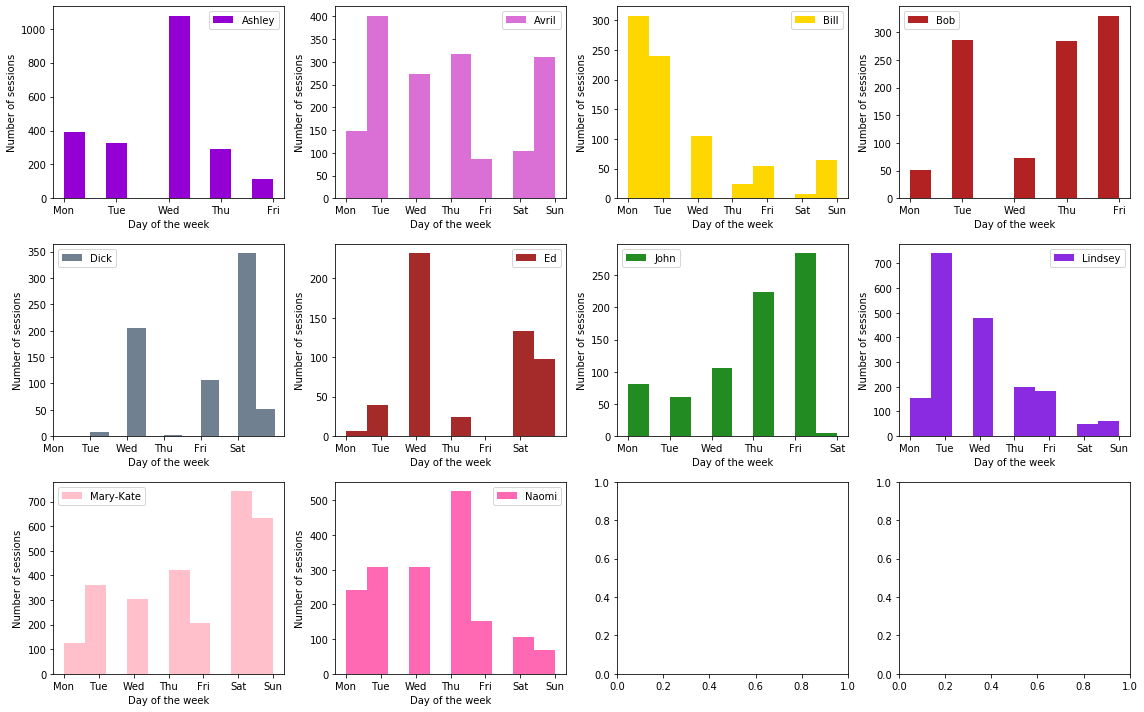

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes = axes.ravel()
for idx, (user, sub_df) in enumerate(pd.DataFrame.groupby(train_data_10users, 'target')):   
    axes[idx].hist(sub_df['day_of_week'], label=user, color=color_dic[user])
    axes[idx].set_xlabel('Day of the week')
    axes[idx].set_ylabel('Number of sessions')
    axes[idx].legend()
    
    axes[idx].set_xticks(np.arange(len(set(sub_df['day_of_week']))))
    axes[idx].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

fig.tight_layout()

The most common session start days in the sample are Tuesday and Wednesday. Around Tuesday are concentrated - Avrill, Bill, Bob, Lindsey, Mary-Kate and (Naomi); around Wednesday - Ashley, Dick, Ed, John and (Naomi).

**Upload the frequency dictionary of sites for 10 users saved earlier in the pickle file:**

In [23]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_dict = pickle.load(f) 

**Top 10 most visited sites (*top10_sites*) and corresponding frequencies (*top10_freqs*):**

In [24]:
top10_sites = sorted(site_dict, key=lambda x: site_dict[x][1], reverse=True)[:10]
top10_freqs = list(map(lambda x: site_dict[x][1], top10_sites))

**Frequency of visits to the top 10 sites:**

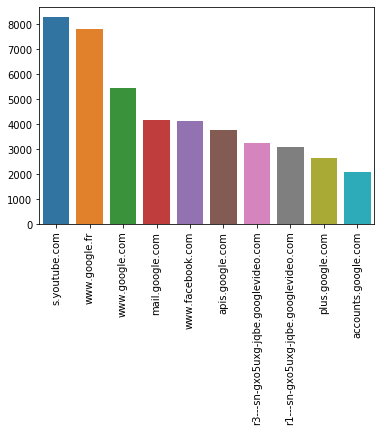

In [25]:
chart = sns.barplot(x=top10_sites, y=top10_freqs)
chart.set_xticklabels(top10_sites, rotation=90)
plt.show()

## Result:
* Additional features are built (session_timespan, #unique_sites, start_hour, day_of_week).
* Visual analysis of the constructed features is performed.

Part 4 (part4_training.ipynb) of the Project will use a "bag" of sites to classify sessions by belonging to different users. The features created in this part will be used, at a certain stage in Part 4, as part of a training sample to improve the quality of the prediction model.